In [10]:
def af(x,activation_function):
  import numpy as np
  if(activation_function=='sigmoid'):
    out=1/(1+np.exp(-x))
  elif(activation_function=='relu'):
    out=x * (x>0) * 1.0
  elif(activation_function=='identical'):
    out=x
  else:
    raise Exception("Sorry, incorrect activation function")

  return out

def round_o_net(o,activation_function):
  import numpy as np
  if(activation_function=='sigmoid'):
    out=o*(1-o)
  elif(activation_function=='relu'):
    out=1.0 * (o>0)
  elif(activation_function=='identical'):
    out=1 * np.ones((np.size(o),1))
  else:
    raise Exception("Sorry, incorrect activation function")

  return out

def DENSE_NN(list_numberOFneurons,num_inputs,list_activation_functions,initializer):
  # initializer = random or zeros
  import numpy as np
  DENSE_NN = {'delta':[] , 'act_out': [],
              'w':[],'b':[],
              'round_w':[],'round_b':[],
              'af':[]}     ## round_w and round_b must be zero in each training iteration
  assert len(list_activation_functions)==len(list_numberOFneurons),'len(list_activation_functions)!=len(list_numberOFneurons)'
  DENSE_NN['af']=list_activation_functions
  num_layers = len(list_numberOFneurons)
  for i in range(0,num_layers,1):
    DENSE_NN['delta'].append(np.zeros((list_numberOFneurons[i],1)))
    DENSE_NN['act_out'].append(np.zeros((list_numberOFneurons[i],1)))
    DENSE_NN['round_b'].append(np.zeros((list_numberOFneurons[i],1)))

    if(initializer=='random'):
      DENSE_NN['b'].append(np.random.rand(list_numberOFneurons[i],1))
    elif(initializer=='zeros'):
      DENSE_NN['b'].append(np.zeros((list_numberOFneurons[i],1)))
    else:
        raise Exception("Sorry, incorrect initializer")

    if(i==0):
      if(initializer=='random'):
        DENSE_NN['w'].append(np.random.rand(list_numberOFneurons[0],num_inputs))
      elif(initializer=='zeros'):
        DENSE_NN['w'].append(np.zeros((list_numberOFneurons[0],num_inputs)))
      else:
        raise Exception("Sorry, incorrect initializer")
      DENSE_NN['round_w'].append(np.zeros((list_numberOFneurons[0],num_inputs)))
    else:
      if(initializer=='random'):
        DENSE_NN['w'].append(np.random.rand(list_numberOFneurons[i],list_numberOFneurons[i-1]))
      elif(initializer=='zeros'):
        DENSE_NN['w'].append(np.zeros((list_numberOFneurons[i],list_numberOFneurons[i-1])))
      else:
        raise Exception("Sorry, incorrect initializer")

      DENSE_NN['round_w'].append(np.zeros((list_numberOFneurons[i],list_numberOFneurons[i-1])))
  return DENSE_NN


In [11]:
def forward_NN(DENSE_NN,input_vec):
  import numpy as np
  num_layers=len(DENSE_NN['delta'])
  input_vec=np.reshape(input_vec,(len(input_vec),1))
  assert num_layers>=1,"num_layers<1"
  assert (len(input_vec)==np.shape(DENSE_NN['w'][0])[1]),"incorrect size of input"
  DENSE_NN['act_out'][0] = af(DENSE_NN['w'][0] @ input_vec + DENSE_NN['b'][0],DENSE_NN['af'][0])

  for i in range(1,num_layers):
    DENSE_NN['act_out'][i] = af(DENSE_NN['w'][i] @ DENSE_NN['act_out'][i-1] + DENSE_NN['b'][i],DENSE_NN['af'][i])

  return DENSE_NN

def predict_NN(DENSE_NN1,input_matrix):

  import numpy as np
  import copy
  DENSE_NN = copy.deepcopy(DENSE_NN1)
  # DENSE_NN=dict(DENSE_NN1.copy())
  size_data = np.shape(input_matrix)
  n_features=np.shape(DENSE_NN['w'][0])[1]
  if(len(size_data)==1 and size_data[0]==n_features):
    n_samples =1
    input_matrix=np.resize(input_matrix,(1,n_features))
  elif(len(size_data)==2 and size_data[1]==n_features):
    n_samples=size_data[0]
  else:
    raise Exception("Sorry, bad data size")
  output_matrix=np.zeros((n_samples,len(DENSE_NN['act_out'][-1])))
  for n in range(0,n_samples):
    DENSE_NN=forward_NN(DENSE_NN,input_matrix[n,:])
    output_matrix[n,:]=np.reshape(DENSE_NN['act_out'][-1],np.size(output_matrix[0,:]))
  return output_matrix

In [12]:
def backward_NN(DENSE_NN,input_vec,output_vec):
  import numpy as np
  num_layers=len(DENSE_NN['delta'])
  output_vec=np.reshape(output_vec,(len(output_vec),1))
  input_vec=np.reshape(input_vec,(len(input_vec),1))
  assert (len(output_vec)==np.shape(DENSE_NN['w'][num_layers-1])[0]),"incorrect size of output"


  aj = DENSE_NN['act_out'][num_layers-1]
  DENSE_NN['delta'][num_layers-1] = ( output_vec - aj ) * round_o_net(aj,DENSE_NN['af'][num_layers-1])
  for layer_l in range(num_layers-2,-1,-1):
    for neuron_j in range(0,len(DENSE_NN['b'][layer_l])):
      aj = DENSE_NN['act_out'][layer_l][neuron_j]
      DENSE_NN['delta'][layer_l][neuron_j] = np.sum( DENSE_NN['w'][layer_l+1][:,neuron_j] * DENSE_NN['delta'][layer_l+1] ) \
                                                 * round_o_net(aj,DENSE_NN['af'][layer_l])

  # first layer
  for neuron_j in range(0,len(DENSE_NN['b'][0])):
    for inp_k in range(0,np.shape(DENSE_NN['w'][0])[1]):
      DENSE_NN['round_w'][0][neuron_j,inp_k] += -1*DENSE_NN['delta'][0][neuron_j,0]*input_vec[inp_k,0]
      DENSE_NN['round_b'][0][neuron_j] += -1*DENSE_NN['delta'][0][neuron_j,0]

  # reminder layers
  for layer_l in range(1,num_layers):
    for neuron_j in range(0,len(DENSE_NN['b'][layer_l])):
      for inp_k in range(0,len(DENSE_NN['b'][layer_l-1])):
        DENSE_NN['round_w'][layer_l][neuron_j,inp_k] += -1* DENSE_NN['delta'][layer_l][neuron_j,0]*DENSE_NN['act_out'][layer_l-1][inp_k,0]
        DENSE_NN['round_b'][layer_l][neuron_j] += -1* DENSE_NN['delta'][layer_l][neuron_j,0]

  return DENSE_NN

In [13]:
def train_DENSE_NN(DENSE_NN,input_matrix,output_matrix,n_samples,n_features,n_outputs,
                   batch_size,n_epoch,learning_rate,verbose):
  import matplotlib.pyplot as plt
  # if(np.shape(input_matrix)[0]==1 and np.shape(output_matrix)[0]==1):
  #   n_samples=1
  #   n_features=np.size(input_matrix)
  #   n_outputs=np.size(output_matrix)
  # elif(len(np.shape(input_matrix)[0])==1 and np.shape(input_matrix)[0]>1 and np.shape(output_matrix)[0]==1):
  #   n_samples=1
  #   n_features=np.size(input_matrix)
  #   n_outputs=np.size(output_matrix)
  # else:
  #   n_samples = np.shape(input_matrix)[0]
  #   n_features = np.shape(input_matrix)[1]
  #   n_outputs = np.shape(output_matrix)[1]
  input_matrix=np.reshape(input_matrix,(n_samples,n_features))
  output_matrix=np.reshape(output_matrix,(n_samples,n_outputs))
  num_layers=len(DENSE_NN['delta'])
  assert (n_samples==np.shape(output_matrix)[0]),'bad data size'
  assert (n_features==np.shape(DENSE_NN['w'][0])[1]),'bad data size'
  assert (n_outputs==np.shape(DENSE_NN['w'][-1])[0]),'bad data size'

  n_iteration=int(np.floor(n_samples/batch_size))
  error=-1*np.ones((n_epoch,1))
  for i in range(0,n_epoch):
    for j in range(0,n_iteration):
      data_train=[]
      lable_train=[]
      data_train = input_matrix[batch_size*j:batch_size*(j+1),:]
      lable_train = output_matrix[batch_size*j:batch_size*(j+1),:]
      for k in range(0,len(DENSE_NN['b']),1):
        DENSE_NN['round_w'][k]=DENSE_NN['round_w'][k]*0
        DENSE_NN['round_b'][k]=DENSE_NN['round_b'][k]*0

      for l in range(0,np.shape(lable_train)[0],1):
        DENSE_NN=forward_NN(DENSE_NN,data_train[l,:])
        DENSE_NN=backward_NN(DENSE_NN,data_train[l,:],lable_train[l,:])
      for m in range(0,num_layers):
        DENSE_NN['w'][m] -= learning_rate/batch_size*DENSE_NN['round_w'][m]
        DENSE_NN['b'][m] -= learning_rate/batch_size*DENSE_NN['round_b'][m]
    output_matrix_predicted=predict_NN(DENSE_NN,input_matrix)
    error[i,0]=np.sum(np.abs(output_matrix_predicted- output_matrix))
    if(verbose==1):print('epoch is',i,'and error is',error[i,0])
  # plt.figure()
  # plt.plot(error)
  # plt.title('training error')
  # plt.show()
  return DENSE_NN,error



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N_samples = 1000
data_dimension = 2
X = np.random.rand(N_samples, data_dimension)
X[0:int(np.shape(X)[0]/2),0]=X[0:int(np.shape(X)[0]/2),0]+0.65
X[0:int(np.shape(X)[0]/2),1]=X[0:int(np.shape(X)[0]/2),1]-0.65
y=np.zeros((N_samples,1))

# np.random.seed(0)
# X = np.random.randn(100, 2)
# y = np.random.choice([-1, 1], size=100)

for i in range(0,np.shape(X)[0]):
  if i<np.shape(X)[0]/2:
    y[i]=0
  else:
    y[i]=+1
a=np.random.permutation(N_samples)
X=X[a,:]
y=y[a]

X_train=X[0:int(np.shape(X)[0]*0.5),:]
X_test=X[int(np.shape(X)[0]*0.5):np.shape(X)[0],:]

y_train=y[0:int(np.shape(X)[0]*0.5)]
y_test=y[int(np.shape(X)[0]*0.5):np.shape(X)[0]]

del(X,y)

plt.figure()
a0=np.where((y_train>0.5)*1)
b0=np.where((y_train<0.5)*1)
plt.scatter(X_train[a0[0],0], X_train[a0[0],1])
plt.scatter(X_train[b0[0],0], X_train[b0[0],1])
# plt.plot(X_train[:,0],-1/(w[1])* (b+w[0]*X_train[:,0]))
plt.title('train')


plt.figure()
a0=np.where((y_test>0.5)*1)
b0=np.where((y_test<0.5)*1)
plt.scatter(X_test[a0[0],0], X_test[a0[0],1])
plt.scatter(X_test[b0[0],0], X_test[b0[0],1])
# plt.plot(X_test[:,0],-1/(w[1])* (b+w[0]*X_test[:,0]))
plt.title('test')

epoch is 0 and error is 164.9191219045709
epoch is 1 and error is 150.66141542345449
epoch is 2 and error is 138.0366669270959
epoch is 3 and error is 126.78967781561737
epoch is 4 and error is 116.716835545821
epoch is 5 and error is 107.65351610772997
epoch is 6 and error is 99.47849884065526
epoch is 7 and error is 92.06591587701718
epoch is 8 and error is 85.32162116420285
epoch is 9 and error is 79.19779600988328
epoch is 10 and error is 73.74355443000881
epoch is 11 and error is 68.87342815049321
epoch is 12 and error is 64.50024881497495
epoch is 13 and error is 60.701160209493786
epoch is 14 and error is 57.48034752289738
epoch is 15 and error is 54.85419454885481
epoch is 16 and error is 52.65382196040894
epoch is 17 and error is 50.68149285047105
epoch is 18 and error is 48.98420714398928
epoch is 19 and error is 47.43249348462255
epoch is 20 and error is 46.07821649451238
epoch is 21 and error is 45.104709886629486
epoch is 22 and error is 44.28898743979809
epoch is 23 and e

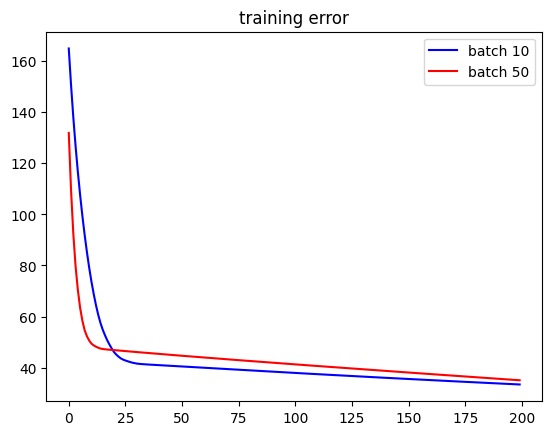

In [50]:
# import time
net1=DENSE_NN([3,1],2,['relu','relu'],'random')
# t = time.time()
net1,error1 =  train_DENSE_NN(net1,X_train,y_train,np.shape(X_train)[0],np.shape(X_train)[1],np.shape(y_train)[1],
                      10,200,0.001,1)
# t2=time.time()
# print(t2-t)
output_matrix_predicted1=predict_NN(net1,X_test)
output_matrix_predicted1=(output_matrix_predicted1>0.5)*1.0
error11=np.sum(np.abs(output_matrix_predicted1- y_test))
print('the test accuracy of first net is: ',100*(1-(error11/np.shape(y_test)[0])))

net2=DENSE_NN([3,1],2,['relu','relu'],'random')
# t = time.time()
net2,error2 =  train_DENSE_NN(net2,X_train,y_train,np.shape(X_train)[0],np.shape(X_train)[1],np.shape(y_train)[1],
                      50,200,0.01,1)
# t2=time.time()
# print(t2-t)

output_matrix_predicted2=predict_NN(net2,X_test)
error22=np.sum(np.abs(output_matrix_predicted2- y_test))
print('the test accuracy of second net is: ',100*(1-(error22/np.shape(y_test)[0])))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(error1,'b')
plt.plot(error2,'r')
plt.legend(['batch 10','batch 50'])
plt.title('training error')
plt.show()


In [ ]:
# comparing sckit-learn SVM and keras_dense and MY_DENSE
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
##-----------------------------------------------------------------------
##----data production-----
N_samples = 200
data_dimension = 2
N_iter=10
MYDENSE_acc_train=np.zeros((N_iter))
MYDENSE_acc_test=np.zeros((N_iter))
MYDENSE_time_train=np.zeros((N_iter))


scikit_acc_train=np.zeros((N_iter))
scikit_acc_test=np.zeros((N_iter))
scikit_time_train=np.zeros((N_iter))


keras_acc_train=np.zeros((N_iter))
keras_acc_test=np.zeros((N_iter))
keras_time_train=np.zeros((N_iter))

for jj in range(N_iter):
  X = np.random.rand(N_samples, data_dimension)
  X[0:int(np.shape(X)[0]/2),0]=X[0:int(np.shape(X)[0]/2),0]+0.65
  X[0:int(np.shape(X)[0]/2),1]=X[0:int(np.shape(X)[0]/2),1]-0.65
  y=np.zeros((N_samples,1))

  # np.random.seed(0)
  # X = np.random.randn(100, 2)
  # y = np.random.choice([-1, 1], size=100)

  for i in range(0,np.shape(X)[0]):
    if i<np.shape(X)[0]/2:
      y[i]=0
    else:
      y[i]=+1
  a=np.random.permutation(N_samples)
  X=X[a,:]
  y=y[a]

  X_train=[]
  X_test=[]
  y_train=[]
  y_test=[]

  X_train=X[0:int(np.shape(X)[0]*0.5),:]
  X_test=X[int(np.shape(X)[0]*0.5):np.shape(X)[0],:]

  y_train=y[0:int(np.shape(X)[0]*0.5),0]
  y_test=y[int(np.shape(X)[0]*0.5):np.shape(X)[0],0]
  y_train=np.reshape(y_train,(len(y_train),1))
  y_test=np.reshape(y_test,(len(y_test),1))

  del(X,y)
##----------------------------------------------------------------------------------
  # define the keras model
  model = Sequential()
  model.add(Dense(3, input_shape=(2,), activation='relu'))
  model.add(Dense(2, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit the keras model on the dataset
  tic = time.time()
  model.fit(X_train, y_train, epochs=200, batch_size=10)
  keras_time_train[jj] = time.time()-tic
  # evaluate the keras model
  _, keras_acc_test[jj] = model.evaluate(X_test, y_test)
  _, keras_acc_train[jj] = model.evaluate(X_train, y_train)
##--------------------------------------------------------------------------------------------
  net1=DENSE_NN([3,2,1],2,['relu','relu','relu'],'random')
  t = time.time()
  net1,error1 =  train_DENSE_NN(net1,X_train,y_train,np.shape(X_train)[0],np.shape(X_train)[1],np.shape(y_train)[1],
                      10,200,0.01,1)
  MYDENSE_time_train[jj]=time.time()-tic
  output_matrix_predicted1=predict_NN(net1,X_test)
  output_matrix_predicted1=(output_matrix_predicted1>0.5)*1.0
  error11=np.sum(np.abs(output_matrix_predicted1- y_test))
  MYDENSE_acc_test[jj]=100*(1-(error11/np.shape(y_test)[0]))

  output_matrix_predicted1=predict_NN(net1,X_train)
  output_matrix_predicted1=(output_matrix_predicted1>0.5)*1.0
  error11=np.sum(np.abs(output_matrix_predicted1- y_train))
  MYDENSE_acc_train[jj]=100*(1-(error11/np.shape(y_train)[0]))

##---------------------------------------------------------------------
  ##--scikit learn SVM---
  clf = svm.SVC()
  tic = time.time()
  clf.fit(X_train, y_train)
  scikit_time_train[jj] = time.time()-tic
  yy=clf.predict(X_train)
  scikit_acc_train[jj]=np.sum(yy==y_train[:,0])/len(y_train)
  yy=clf.predict(X_test)
  scikit_acc_test[jj]=np.sum(yy==y_test[:,0])/len(y_test)


In [52]:
##--------------------------------------------------------------------
print('MYDENSE_acc_train',np.mean(MYDENSE_acc_train))
print('MYDENSE_acc_test',np.mean(MYDENSE_acc_test))
print('MYDENSE_time_train',np.mean(MYDENSE_time_train))

print('scikit_acc_train',np.mean(scikit_acc_train))
print('scikit_acc_test',np.mean(scikit_acc_test))
print('scikit_time_train',np.mean(scikit_time_train))

print('keras_acc_train',np.mean(keras_acc_train))
print('keras_acc_test',np.mean(keras_acc_test))
print('keras_time_train',np.mean(keras_time_train))

MYDENSE_acc_train 92.0
MYDENSE_acc_test 91.6
MYDENSE_time_train 16.554498410224916
scikit_acc_train 0.9520000000000002
scikit_acc_test 0.9479999999999998
scikit_time_train 0.0026267290115356444
keras_acc_train 0.8659999966621399
keras_acc_test 0.847000002861023
keras_time_train 10.043565392494202
